# Pipeline Band power

## Introduction
This notebook is a part of the project to compare the performance of different pipelines for EEG elbow movement classification. The goal of these notebooks is to establish a standard pipeline for EEG elbow movement classification. 

This notebook explores the performance of the BP pipeline. The pipeline is composed of 3 main steps:
1. Feature extraction: band power
2. Classification: Logistic regression, Linear discriminant analysis, Support vector machine, Random forest
3. Evaluation: Balanced accuracy

## Understanding the pipeline

Power bands are a concept frequently used in signal processing, especially in the context of analyzing physiological signals such as EEG (electroencephalogram) data. They represent specific ranges of frequencies within a signal that are associated with different types of brain activity or physical states. The division of the frequency spectrum into bands helps in isolating the contributions of various types of brain waves to overall brain activity, each associated with different states of consciousness, cognitive processes, or physiological states.

### Common Power Bands

The frequency spectrum is typically divided into the following bands:

- Delta (δ): 0.5–4 Hz, associated with deep sleep and regenerative processes.
- Theta (θ): 4–8 Hz, related to drowsiness, relaxation, and the transition between wakefulness and sleep.
- Alpha (α): 8–12 Hz, linked to a relaxed but awake state, often observed when the eyes are closed but the person is awake.
- Beta (β): 12–30 Hz, connected to active thinking, problem-solving, and focused attention.
- Gamma (γ): Over 30 Hz, associated with high-level information processing and cognitive functioning.

### Application and Analysis

Analyzing power bands involves extracting the amplitude or power of the signal within each frequency range. This can reveal important information about a person's mental state, attention levels, or neurological health. Power bands are crucial for various applications, including cognitive neuroscience research, clinical diagnostics, and brain-computer interfaces.



## Methodology

In this notebook we aim to establish the performance of the rieman pipeline. Here are the steps we will follow:

1. Preprocessing:
    - Loading the data from each .npy file using Dataloader built for this project.
    - Using only the session which record the movement of the arm oposite to stroke side. (REQUIREMENT)
    - Using only the electrodes from the stroke side. (REQUIREMENT)
    - Labeling the data using the acceleration (done in the dataloader, see [labelling_data.ipynb](./../exploration_data/labelling_data.ipynb) for the exact process)
    - Filtering the data between 1 and 40 Hz.
    - Getting the train and test data by epoching around the movement onset. 1=extension 2=flexion 0=rest(or no onset to be precise) To get data labelled 0 we took epoch from 4s to 1s before movement onset.
    - Relabelling extension and flexion as 1 and no onset as 0.

2. Feature extraction:
    - **Power Spectral Density (PSD):**\
    The initial step involves computing the Power Spectral Density (PSD) of EEG signals. The PSD estimates how power (or variance) of a signal is distributed across different frequency bands. This is essential for quantifying the intensity of brain activity within specific frequency ranges (such as Delta, Theta, Alpha, Beta, and Gamma bands) across different EEG channels. By doing this, we can capture the dominant frequencies of brain activity during various states of consciousness or cognitive tasks.
    - **Band Power Features:**\
    Following the PSD calculation, the signal's power is summed or averaged over the predefined frequency bands to extract band power features. This step isolates the contribution of each power band to the overall signal, allowing for a clearer understanding of brain wave patterns associated with different mental states or activities. Extracting band power features simplifies the complex information present in the full frequency spectrum into more manageable and interpretable segments.
    - **Logarithmic Transformation:**\
    Often, the band power features undergo a logarithmic transformation. This step is taken to normalize the distribution of power values, as they can span several orders of magnitude. The logarithmic transformation ensures that subsequent analysis is not unduly influenced by very high or very low power values, thus making the features more robust and easier to compare across different conditions or subjects.
    - **Feature Scaling:**\
    Similar to the standard scaler step in Riemannian pipelines, feature scaling is applied to the extracted log-transformed band power features. This ensures that each feature contributes equally to the analysis, preventing features with larger magnitudes from dominating the machine learning models. Standardization (subtracting the mean and dividing by the standard deviation) or Min-Max normalization (scaling the features to a fixed range) are common scaling techniques used at this stage.
    
3. Classification: (compared differents classifiers)
    -  Logistic regression
    -  Linear discriminant analysis
    -  Support vector machine
    -  Random forest
    -  AdaBoost
    -  MLP
    
4. Evaluation:
    1. Evaluation on epoched data. Using balanced accuracy to evaluate the performance of the pipeline using 3 differents testers:
        -  Tester 1: Seen session / seen subject (but not the same data)
        -  Tester 2: Unseen session / seen subject (but not the same data)
        -  Tester 3: Unseen session / unseen subject
    2. Evaluation on continuous data : estimating the performance by visual feedback with density of prediction.

In [7]:
from ml_eeg_tools.preprocessing import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import mne
import os

## Hyperparameters

In [6]:
NUMBER_OF_SESSIONS = 10

# Fréquence de filtrage
FMIN = 1
FMAX = 40

# Bornes époques
EPOCHS_TMIN = -1
EPOCHS_LENGTH = 3
EPOCHS_TMAX = EPOCHS_TMIN + EPOCHS_LENGTH

# temps depuis le mouvement pour époquer autours d'une plage sans mouvement
EPOCHS_EMPTY_FROM_MVT_TMINS = -4

BINARY_CLASSIFICATION = True

RANDOM_STATE = 42
N_SPLIT = 4

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

## Preprocessing

In [14]:
from ml_eeg_tools.preprocessing.data_preparation import prepare_data_train

settings_prepare_data = {
        "FMIN": FMIN,
        "FMAX": FMAX,
        "EPOCHS_TMIN": EPOCHS_TMIN,
        "EPOCHS_EMPTY_FROM_MVT_TMIN": EPOCHS_EMPTY_FROM_MVT_TMINS,
        "EPOCHS_TMAX": EPOCHS_TMAX,
        "BINARY_CLASSIFICATION": True,
        "RANDOM_STATE": RANDOM_STATE,
    }

data_patients, labels_patients, _, _ = prepare_data_train(
            FILE_PATH_LIST[: NUMBER_OF_SESSIONS], settings_prepare_data
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


## Pipeline

In [9]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import pandas as pd
from joblib import dump, load
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import welch

### The pipeline definition

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import mne

class BandPowerExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sfreq=1024, freq_bands=[(1, 4), (4, 8), (8, 13), (13, 30), (30, 45)], n_samples=3073, verbose=False):
        self.sfreq = sfreq
        self.freq_bands = freq_bands
        self.n_samples = n_samples
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = np.empty((X.shape[0], len(self.freq_bands)))
        for i, epoch in enumerate(X):
            # Redimensionner l'époque en tableau 3D
            epoch = np.reshape(epoch, (1, 37, -1))
            if i == 0 and self.verbose:
                print(f'epoch.shape: {epoch.shape}')
            power, _ = mne.time_frequency.psd_array_multitaper(epoch, fmin=self.freq_bands[0][0], fmax=self.freq_bands[-1][1], sfreq=1024)
            if i == 0 and self.verbose:
                print(f'power.shape: {power.shape}')
            for j, freq_band in enumerate(self.freq_bands):
                X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
            if i == 0 and self.verbose:
                print(f'X_transformed[i]: {X_transformed[i]}')
        return X_transformed

preproc_steps = [
    ('band_power', BandPowerExtractor),
    ('ss', StandardScaler)
]


In [17]:
pipeline_steps = [(name, step()) for (name, step) in preproc_steps] + [('clf', RandomForestClassifier())]
    
pipeline = Pipeline(pipeline_steps)

### Fit

In [15]:
X_train = []
y_train = []
for i in range(len(data_patients)):
    for j in range(len(data_patients[i])):
        X_train.append(data_patients[i][j])
        y_train.append(labels_patients[i][j])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(X_train.shape, y_train.shape)

pipeline.fit(X_train, y_train)

(350, 37, 3073) (350,)


C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))


Pipeline(steps=[('band_power', BandPowerExtractor()), ('ss', StandardScaler()),
                ('clf', RandomForestClassifier())])

### Tests A, B, C, X

In [16]:
from ml_eeg_tools.test_model.test_epoch import (
    train_test_A,
    train_test_B,
    train_test_C,
    train_test_X,
)

scores = []
for score_fn in [train_test_A, train_test_B, train_test_C, train_test_X]:
    score = score_fn(
        data_patients,
        labels_patients,
        pipeline,
        RANDOM_STATE=RANDOM_STATE,
        N_SPLIT=N_SPLIT,
        verbose=False,
    )
    print(f'{score_fn.__name__}: {score}')
    scores.append(score)
    
df = pd.DataFrame(
    {
        "Score A": [scores[0]],
        "Score B": [scores[1]],
        "Score C": [scores[2]],
        "Score X": [scores[3]],
    }
) 


C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

train_test_A: 0.7276775980560146


C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

train_test_B: 0.7067307692307692


C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

train_test_C: 0.48511904761904756


C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))
C:\Users\julie\AppData\Local\Temp\ipykernel_16840\3837959076.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

train_test_X: 0.7001312869194052


In [43]:
steps_str_list = [step[1].__class__.__name__ for step in pipeline.steps]
df['mean_score_ABC'] = np.mean(scores[:3])
for i, step in enumerate(steps_str_list):
    df[f'step {i+1}'] = step

In [51]:
df

,Score A,Score B,Score C,Score X,mean_score_ABC,step 1,step 2,step 3
0,0.727678,0.706731,0.485119,0.700131,0.639842,BandPowerExtractor,StandardScaler,RandomForestClassifier


## Many classifiers

In [ ]:
pipelines = []

for model in [RandomForestClassifier, SVC, LogisticRegression, LinearDiscriminantAnalysis, AdaBoostClassifier, MLPClassifier]:
    pipelines_steps = [(name, step()) for (name, step) in preproc_steps] + [('clf', model())]
    pipelines.append(Pipeline(pipelines_steps))
    
scores_pipeline = []
for pipeline in pipelines:
    scores = []
    for score_fn in [train_test_A, train_test_B, train_test_C, train_test_X]:
        score = score_fn(
            data_patients,
            labels_patients,
            pipeline,
            RANDOM_STATE=RANDOM_STATE,
            N_SPLIT=N_SPLIT,
            verbose=False,
        )
        print(f'pipeline clf: {pipeline.steps[-1][1].__class__.__name__}')
        print(f'{score_fn.__name__}: {score}')
        scores.append(score)
    scores_pipeline.append(scores)

    df = df.append(
        pd.DataFrame(
            {
                "clf": [pipeline.steps[-1][1].__class__.__name__],
                "Score A": [scores[0]],
                "Score B": [scores[1]],
                "Score C": [scores[2]],
                "Score X": [scores[3]],
            }
        )
    )


### Save model



In [18]:
# best_pipeline = pipelines[np.argmax(np.mean(scores_pipeline[:3], axis=1))]
# best_pipeline_scores = scores_pipeline[np.argmax(np.mean(scores_pipeline[:3], axis=1))]

best_pipeline = pipeline
best_pipeline_scores = ['0.727678',	'0.706731',	'0.485119', '0.700131']

X_train = []
y_train = []
for i in range(len(data_patients)):
    for j in range(len(data_patients[i])):
        X_train.append(data_patients[i][j])
        y_train.append(labels_patients[i][j])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

best_pipeline.fit(X_train, y_train)

C:\Users\julie\AppData\Local\Temp\ipykernel_4264\715453917.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))


Pipeline(steps=[('band_power', BandPowerExtractor()), ('ss', StandardScaler()),
                ('clf', RandomForestClassifier())])

In [19]:
import time
PATH_SAVE = './models/'
date = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
steps_str_list = [step[1].__class__.__name__ for step in best_pipeline.steps]
steps_str = '_'.join(steps_str_list)
NAME_MODEL = f'model_{steps_str}_{date}.joblib'

model_info = {
    'pipeline': best_pipeline,
    'name': NAME_MODEL,
    'additional_info': {
        'aim': 'Binary classification of EEG signals to detect movement',
        'date_of_training': date,
        'data_preprocessing_details':  best_pipeline.steps,
        'model_parameters': best_pipeline.get_params(),
        'preprocessing_parameters': {
            'FMIN': FMIN,
            'FMAX': FMAX,
            'EPOCHS_TMIN': EPOCHS_TMIN,
            'EPOCHS_TMAX': EPOCHS_TMAX,
            'EPOCHS_EMPTY_FROM_MVT_TMINS': EPOCHS_EMPTY_FROM_MVT_TMINS,
            'BINARY_CLASSIFICATION': BINARY_CLASSIFICATION,
            'RANDOM_STATE': RANDOM_STATE,
            'N_SPLIT': N_SPLIT,
            'NUMBER_OF_SESSIONS': NUMBER_OF_SESSIONS
        },
        'model_performance': {
            f'Score {z}': best_pipeline_scores[i] for i, z in enumerate(['A', 'B', 'C', 'X'])
        }
    }
}

if not os.path.exists(PATH_SAVE):
    os.makedirs(PATH_SAVE)
dump(model_info, PATH_SAVE + NAME_MODEL)

['./models/model_BandPowerExtractor_StandardScaler_RandomForestClassifier_2024-03-07_16-20-46.joblib']

## Evaluation on continuous data

In [3]:
from joblib import load
import os
from ml_eeg_tools.inference import prepare_data_inference, creating_sliding_windows
from ml_eeg_tools.test_model import density_on_prediction, density_plot


In [11]:
WINDOWS_SIZE = 1.7
WINDOWS_STEP = 0.2

PATH_SAVE = './models/'
NAME_MODEL = 'model_BandPowerExtractor_StandardScaler_RandomForestClassifier_2024-03-07_16-20-46.joblib'
FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

pipeline = load(PATH_SAVE + NAME_MODEL, )

# Prétraitement basé sur la sélection de l'utilisateur
raws  = prepare_data_inference(FILE_PATH_LIST[11], fmin=FMIN, fmax=FMAX)

# Transformation des données eeg en fenêtres glissantes pour traitement dans le classifieur
windows = creating_sliding_windows(raws, WINDOWS_SIZE, WINDOWS_STEP)

# Prédiction basés sur les données EEG reçues
predictions = pipeline['pipeline'].predict(windows)

# Reconstruction de la prédiction sur le signal temporel (densité de prédiction)
movement_density = density_on_prediction(raws, predictions, window_size=WINDOWS_SIZE, window_step=WINDOWS_STEP)


C:\Users\julie\AppData\Local\Temp\ipykernel_19840\715453917.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_transformed[i, j] = np.mean(power[:, freq_band[0]:freq_band[1]], axis=(1, 2))


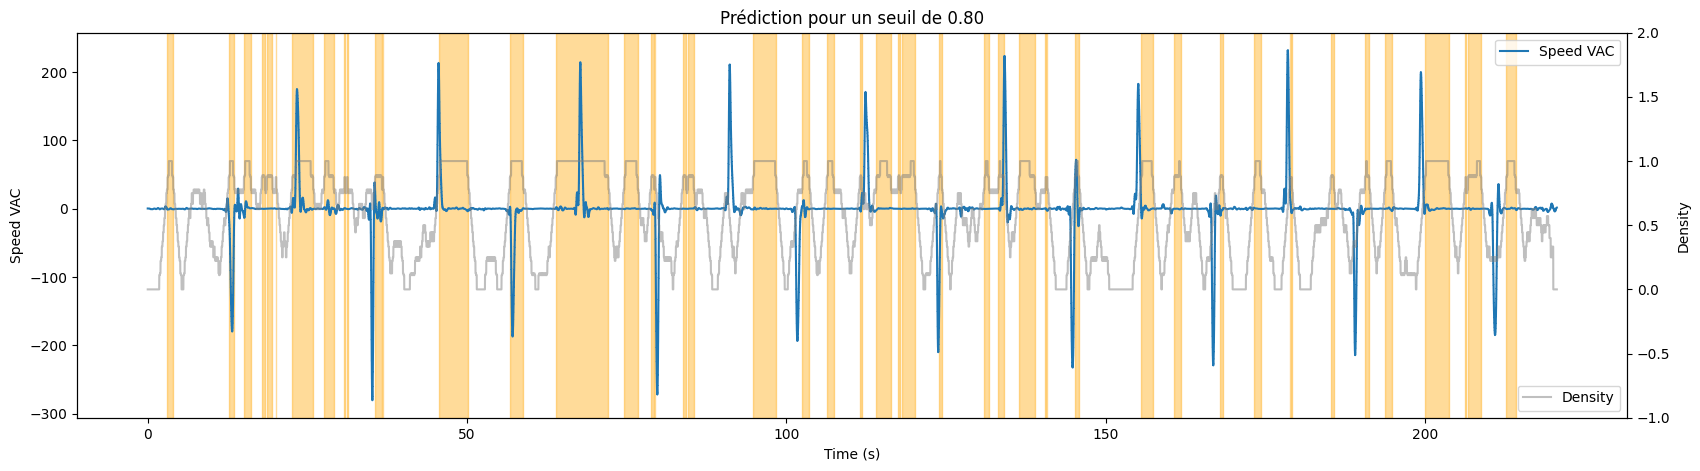

In [12]:
THRESHOLD_DENSITY_PREDICTION = 0.8

movement_times = density_plot(
        raws,
        movement_density,
        threshold=THRESHOLD_DENSITY_PREDICTION,
        plot_density=True,
    )

In [13]:
pd.DataFrame(pipeline['additional_info']['model_performance'], index=[0])

,Score A,Score B,Score C,Score X
0,0.727678,0.706731,0.485119,0.700131


In [14]:
NUMBER_OF_SESSIONS

10